In [1]:
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

import qiskit.tools.jupyter
%qiskit_version_table
#%qiskit_copyright

In [2]:
import numpy as np
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test import mock
from xbm import get_all_meas_circs_bits_coefs
from pauli import get_all_meas_circs_bits_coefs_pauli
from utils import eval_expectation_listed
import time
import copy
import random
import yaml
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
seed = 42
shots = 8192

nb_qubits = 4
nb_trial = 10
is_psi_1 = False
fname = 'results_real_device_exp2_4qubits'

device = 'IBMQ'
#device = 'QASM'

if True:
    fake_device = QasmSimulator.from_backend(mock.FakeSydney())
    coupling_map = fake_device.configuration().coupling_map
    noise_model = NoiseModel.from_backend(fake_device)
else:
    noise_model, coupling_map = None, None

In [4]:
# Rename to your config file
with open('ibmq_config.yaml') as file:
    config = yaml.safe_load(file)
    
IBMQ.save_account(config['token'], overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub=config['provider']['hub'], group=config['provider']['group'], project=config['provider']['project'])

In [5]:
quantum_instance_statevec = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_simulator=seed, seed_transpiler=seed)
quantum_instance_qasm     = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=shots, seed_simulator=seed, seed_transpiler=seed, coupling_map=coupling_map, noise_model=noise_model)
quantum_instance_ibmq     = QuantumInstance(provider.get_backend(config['backend']), seed_transpiler=seed, shots=shots)

In [6]:
def experiments(psi_0_list, psi_1_list, mat_A_list, meas_list, qasm=True, ibmq=True):

    expectation_gt_list = []
    for psi_0, psi_1, mat_A in zip(psi_0_list, psi_1_list, mat_A_list):
        p0 = quantum_instance_statevec.execute(psi_0).get_statevector()
        if psi_1 is not None:
            p1 = quantum_instance_statevec.execute(psi_1).get_statevector()
            expectation_gt = (np.conjugate(p0)*(mat_A @ p1)).sum()
        else:
            expectation_gt = (np.conjugate(p0)*(mat_A @ p0)).sum()
        expectation_gt_list += [expectation_gt]

    expectation_statevec_list, results = eval_expectation_listed(copy.deepcopy(meas_list), quantum_instance_statevec, params_dict=None)
    
    res = {'GT':expectation_gt_list, 'statevec':expectation_statevec_list}
    
    if not all(np.isclose(np.ravel(expectation_gt_list), np.ravel(expectation_statevec_list))):
        print(expectation_gt_list)
        print(expectation_statevec_list)
        plt.scatter(np.real(np.ravel(expectation_gt_list)), np.real(np.ravel(expectation_statevec_list)))
        plt.scatter(np.imag(np.ravel(expectation_gt_list)), np.imag(np.ravel(expectation_statevec_list)))
        plt.axes().set_aspect('equal')
        raise ValueError()

    if qasm:
        expectation_qasm_list, results = eval_expectation_listed(copy.deepcopy(meas_list), quantum_instance_qasm, params_dict=None)
        res.update({'QASM':expectation_qasm_list})

    if ibmq:
        expectation_ibmq_list, results = eval_expectation_listed(copy.deepcopy(meas_list), quantum_instance_ibmq, params_dict=None)
        res.update({'IBMQ':expectation_ibmq_list})
    
    return res

In [7]:
if device=='IBMQ':
    qasm, ibmq = False, True
elif device=='QASM':
    qasm, ibmq = True, False
else:
    raise NotImplementedError()

In [8]:
nb_elements = 4**nb_qubits
psi_0_list = []
psi_1_list = []
mat_A_list = []
meas_pauli_list = []
meas_xbm_list = []

for trial in range(nb_trial):
    for j in range(nb_elements):
        np.random.seed(trial)
        random.seed(trial)
        psi_0 = QuantumCircuit(nb_qubits)
        for i in range(nb_qubits):
            psi_0.h(i)

        mat_A = np.zeros((4**nb_qubits,)).astype(np.complex128)
        foo = np.random.random() * random.choice([1,-1])
        foo += 1j * np.random.random() * random.choice([1,-1])
        mat_A[j] = foo
        mat_A = np.reshape(mat_A, (2**nb_qubits,2**nb_qubits))
        psi_1 = None
        psi_0_list += [psi_0]
        psi_1_list += [None]
        mat_A_list += [mat_A]
        meas_pauli_list += [get_all_meas_circs_bits_coefs_pauli(psi_0, psi_1, mat_A, reduce=False)]
        meas_xbm_list += [get_all_meas_circs_bits_coefs(psi_0, psi_1, mat_A)]

In [9]:
if False:
    with open(fname+'.pkl', 'rb') as f:
        results = pickle.load(f)
        res_xbm = results['XBM']
        res_pauli = results['Pauli']
else:
    res_xbm = experiments(psi_0_list, psi_1_list, mat_A_list, meas_xbm_list, qasm=qasm, ibmq=ibmq)
    res_pauli = experiments(psi_0_list, psi_1_list, mat_A_list, meas_pauli_list, qasm=qasm, ibmq=ibmq)
    with open(fname+'.pkl', 'wb') as f:
        pickle.dump({'XBM':res_xbm, 'Pauli':res_pauli}, f)

In [10]:
def get_abs_errors(res, nb_trial=10):
    
    abs_errors = []
    for gt, evaluated in zip(res['GT'],res[device]):
        abs_error = np.abs(gt-evaluated)
        abs_errors += [abs_error]
    abs_errors = np.array(abs_errors).reshape((nb_trial,2**nb_qubits,2**nb_qubits))
    
    return abs_errors


def get_rel_errors(res, nb_trial=10):
    
    rel_errors = []
    for gt, evaluated in zip(res['GT'],res[device]):
        rel_error = np.abs(gt-evaluated)/np.abs(gt)
        rel_errors += [rel_error]
    rel_errors = np.array(rel_errors).reshape((nb_trial,2**nb_qubits,2**nb_qubits))
    
    return rel_errors

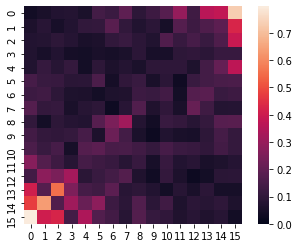

In [11]:
vmax = get_rel_errors(res_xbm).mean(0).max()
sns.heatmap(get_rel_errors(res_xbm).mean(0), annot=False, vmin=0, vmax=vmax)
plt.axes().set_aspect('equal')
plt.savefig('elementwise-error-xbm.pdf')

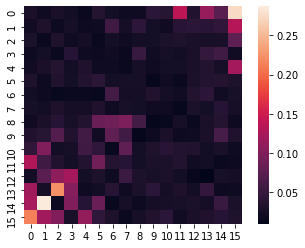

In [12]:
sns.heatmap(get_rel_errors(res_xbm).std(0), annot=False)
plt.axes().set_aspect('equal')

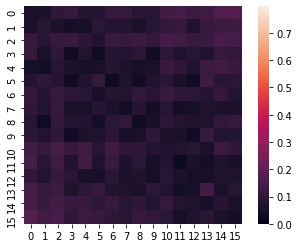

In [13]:
sns.heatmap(get_rel_errors(res_pauli).mean(0), annot=False, vmin=0, vmax=vmax)
plt.axes().set_aspect('equal')
plt.savefig('elementwise-error-naive.pdf')

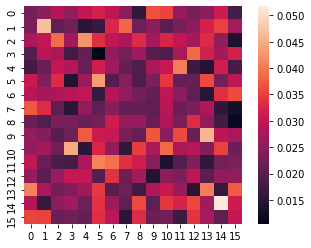

In [14]:
sns.heatmap(get_rel_errors(res_pauli).std(0), annot=False)
plt.axes().set_aspect('equal')